In [6]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, homogeneity_score, completeness_score,silhouette_score, davies_bouldin_score, calinski_harabasz_score, confusion_matrix
import seaborn as sns
from collections import Counter



In [4]:
model = torch.load('model.pth')
model.eval() 
feature_extractor = nn.Sequential(*list(model.children())[:-1])

C:\Users\anoop\AppData\Local\Temp\ipykernel_19808\2391741073.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model.pth')


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = torch.load('model.pth', map_location=device)
feature_extractor = nn.Sequential(*list(model.children())[:-1])
feature_extractor.to(device)  
feature_extractor.eval()  

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

extraction_path = './lung_colon_image_set'
train_dir = os.path.join(extraction_path, 'train')
val_dir = os.path.join(extraction_path, 'val')
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

def extract_features(loader, output_path):
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)  
            features = feature_extractor(images)
            features = features.view(features.size(0), -1) 
            all_features.append(features.cpu().numpy())  
            all_labels.append(labels.numpy())

    
    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    
    np.save(os.path.join(output_path, 'features.npy'), all_features)
    np.save(os.path.join(output_path, 'labels.npy'), all_labels)
    print(f"Features and labels saved to {output_path}")

current_directory = '.'
os.makedirs(os.path.join(current_directory, 'train_features'), exist_ok=True)
os.makedirs(os.path.join(current_directory, 'val_features'), exist_ok=True)
extract_features(train_loader, os.path.join(current_directory, 'train_features'))
extract_features(val_loader, os.path.join(current_directory, 'val_features'))


C:\Users\anoop\AppData\Local\Temp\ipykernel_19808\2144828936.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model.pth', map_location=device)


Features and labels saved to .\train_features
Features and labels saved to .\val_features


In [4]:
train_features_path = './train_features/features.npy'
train_labels_path = './train_features/labels.npy'
val_features_path = './val_features/features.npy'
val_labels_path = './val_features/labels.npy'


train_features = np.load(train_features_path)
train_labels = np.load(train_labels_path)
val_features = np.load(val_features_path)
val_labels = np.load(val_labels_path)


print("Training Features Shape:", train_features.shape)
print("Training Labels Shape:", train_labels.shape)
print("Validation Features Shape:", val_features.shape)
print("Validation Labels Shape:", val_labels.shape)


print("\nSample Training Features:\n", train_features[:5])
print("\nSample Training Labels:\n", train_labels[:5])
print("\nSample Validation Features:\n", val_features[:5])
print("\nSample Validation Labels:\n", val_labels[:5])


Training Features Shape: (20000, 512)
Training Labels Shape: (20000,)
Validation Features Shape: (5000, 512)
Validation Labels Shape: (5000,)

Sample Training Features:
 [[0.37328225 0.7793217  0.         ... 0.47892156 4.6908836  0.        ]
 [0.02340906 0.22486019 0.         ... 0.7041856  2.2570982  0.        ]
 [0.08824251 0.11541463 0.         ... 0.5602702  2.3412232  0.        ]
 [0.04275075 0.06786998 0.         ... 0.39100966 1.7652335  0.        ]
 [0.18074761 0.02552767 0.         ... 0.51832414 2.2061675  0.        ]]

Sample Training Labels:
 [0 0 0 0 0]

Sample Validation Features:
 [[1.6346755e-03 2.9889652e-01 0.0000000e+00 ... 2.3815171e-01
  1.8790027e+00 0.0000000e+00]
 [1.9480857e-01 5.9372342e-01 0.0000000e+00 ... 4.2887554e-01
  3.7118025e+00 0.0000000e+00]
 [5.4577183e-02 2.7169436e-01 0.0000000e+00 ... 2.7028674e-01
  2.4340670e+00 0.0000000e+00]
 [6.1486572e-02 5.2786458e-01 0.0000000e+00 ... 1.7819439e-01
  2.9125178e+00 0.0000000e+00]
 [9.5388062e-02 3.290441

Cluster centers:
[[5.3360730e-02 2.1508890e-01 6.4469278e-03 ... 1.8709821e-01
  1.1038322e+00 3.0496120e-03]
 [9.6239674e-01 2.0705020e+00 6.0801387e-02 ... 2.7312577e-02
  5.4866016e-01 1.1381501e-01]
 [2.0518703e+00 2.8610229e-04 3.2779562e+00 ... 3.8386314e+00
  8.7089956e-02 3.0643322e+00]
 [1.2866247e-01 1.3568478e+00 1.6739048e-01 ... 8.0032170e-02
  1.7400014e+00 1.1623943e-01]
 [3.2759160e-01 6.3629746e-03 1.2040728e+00 ... 1.9851131e+00
  9.9322200e-02 1.1491083e+00]]
First 10 cluster labels:
[0 0 0 0 0 0 0 0 0 0]


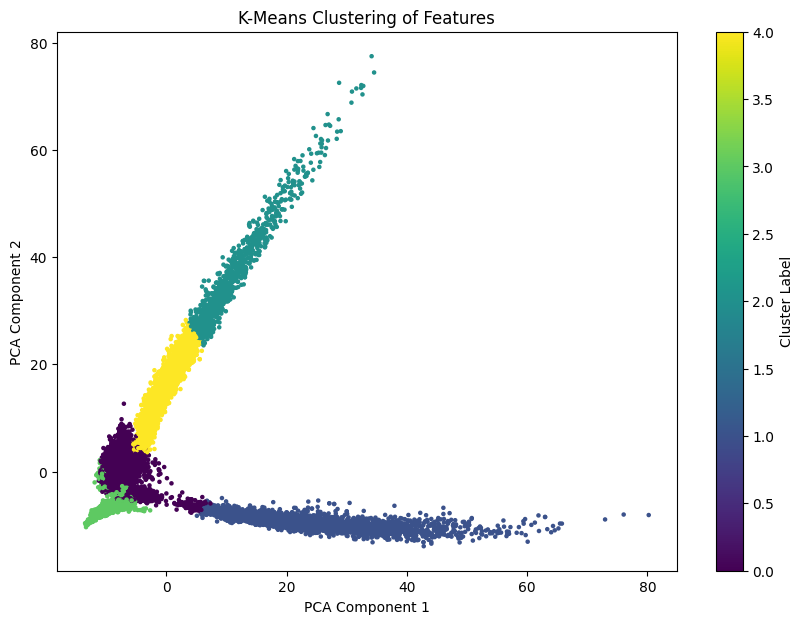

In [19]:
train_features_path = './train_features/features.npy'
train_features = np.load(train_features_path)
num_clusters = 5 
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(train_features)
print(f"Cluster centers:\n{kmeans.cluster_centers_}")
print(f"First 10 cluster labels:\n{cluster_labels[:10]}")
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(train_features)
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='viridis', s=5)
plt.colorbar(scatter, label='Cluster Label')
plt.title('K-Means Clustering of Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


Updated Cluster centers:
[[1.5834868e-03 1.4384764e-01 4.9880743e-03 ... 4.3631911e-02
  1.4428765e-01 1.9219220e-03]
 [7.6939619e-01 1.9693396e+00 4.5174509e-02 ... 2.4337530e-02
  5.3657901e-01 5.6856424e-02]
 [1.5291389e+00 3.7884712e-04 2.7537916e+00 ... 3.3603418e+00
  8.9877784e-02 2.5737376e+00]
 ...
 [4.2390466e-02 1.2537490e+00 1.0734758e-01 ... 6.6136777e-02
  1.5116519e+00 7.5589746e-02]
 [4.3949139e-01 1.8887262e+00 4.0384281e-01 ... 1.1310178e-01
  2.5334864e+00 2.7658498e-01]
 [1.5961902e+00 2.6073365e+00 7.6557249e-02 ... 1.9877791e-02
  6.1476040e-01 1.9040263e-01]]
First 10 updated cluster labels:
[ 4 14 14 14 14 14 16 16  4 12]


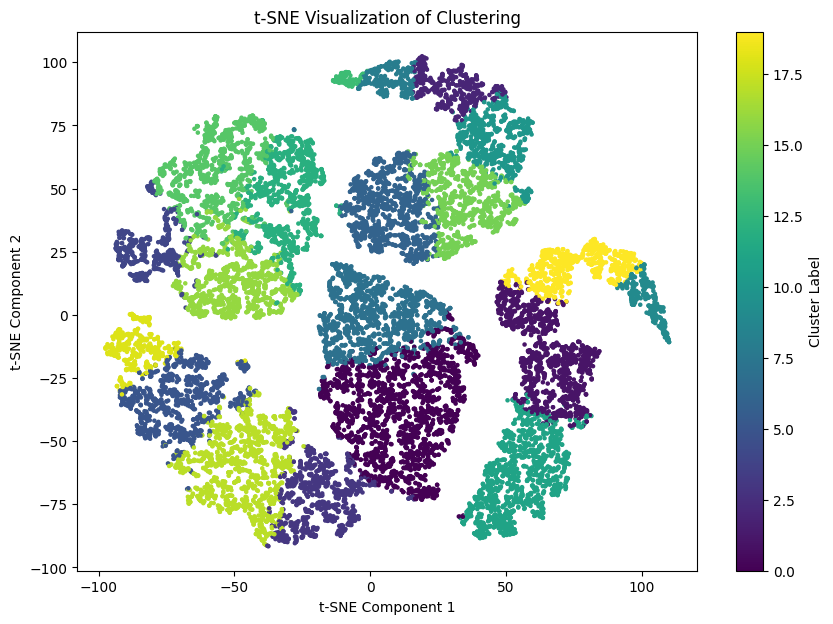

In [9]:
num_clusters = 20  
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=0)
cluster_labels = kmeans.fit_predict(train_features)

print(f"Updated Cluster centers:\n{kmeans.cluster_centers_}")
print(f"First 10 updated cluster labels:\n{cluster_labels[:10]}")
pca = PCA(n_components=50) 
reduced_features = pca.fit_transform(train_features)

tsne = TSNE(n_components=2, random_state=0)
reduced_features_2d = tsne.fit_transform(reduced_features)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_features_2d[:, 0], reduced_features_2d[:, 1], c=cluster_labels, cmap='viridis', s=5)
plt.colorbar(scatter, label='Cluster Label')
plt.title('t-SNE Visualization of Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


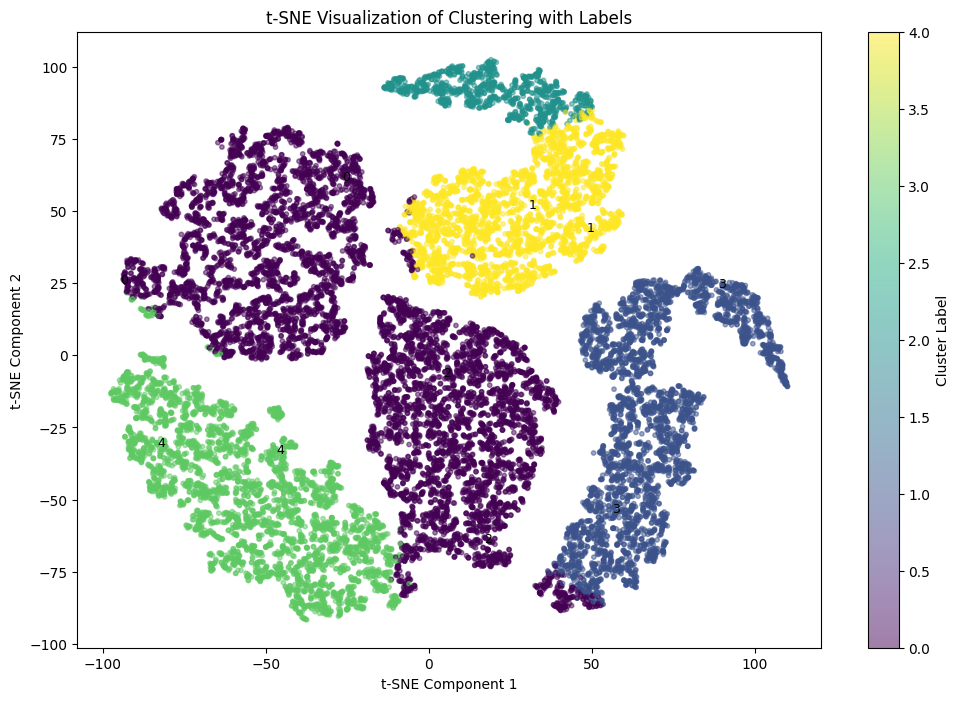

In [8]:
train_features = np.load('train_features/features.npy')
train_labels = np.load('train_features/labels.npy')
n_clusters = 5  
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(train_features)
pca = PCA(n_components=50)  
reduced_features = pca.fit_transform(train_features)


tsne = TSNE(n_components=2, random_state=0)
reduced_features_2d = tsne.fit_transform(reduced_features)


plt.figure(figsize=(12, 8))
scatter = plt.scatter(reduced_features_2d[:, 0], reduced_features_2d[:, 1], c=cluster_labels, cmap='viridis', s=10, alpha=0.5)
plt.colorbar(scatter, label='Cluster Label')


for i in range(0, len(reduced_features_2d), len(reduced_features_2d)//10):
    plt.text(reduced_features_2d[i, 0], reduced_features_2d[i, 1], str(train_labels[i]), fontsize=9, ha='right')

plt.title('t-SNE Visualization of Clustering with Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()



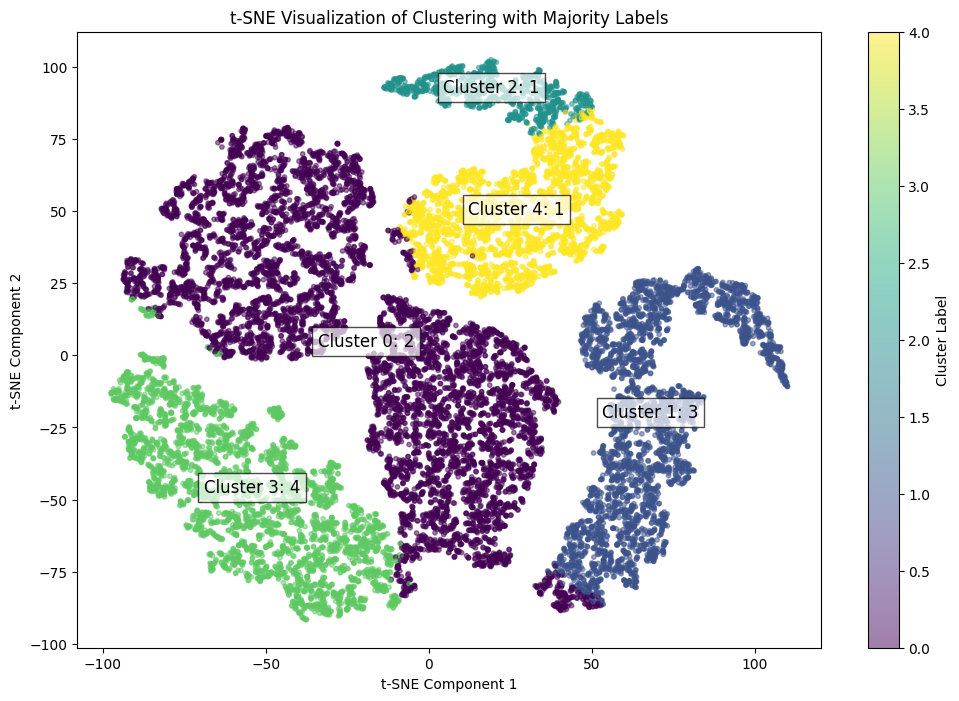

In [9]:
train_features = np.load('train_features/features.npy')
train_labels = np.load('train_features/labels.npy')


n_clusters = 5  
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(train_features)


def get_majority_label(labels, cluster_labels):
    cluster_label_mapping = {}
    for cluster_id in np.unique(cluster_labels):
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        cluster_labels_for_indices = labels[cluster_indices]
        majority_label = Counter(cluster_labels_for_indices).most_common(1)[0][0]
        cluster_label_mapping[cluster_id] = majority_label
    return cluster_label_mapping

cluster_label_mapping = get_majority_label(train_labels, cluster_labels)

mapped_labels = np.array([cluster_label_mapping[label] for label in cluster_labels])


pca = PCA(n_components=50)
reduced_features = pca.fit_transform(train_features)


tsne = TSNE(n_components=2, random_state=0)
reduced_features_2d = tsne.fit_transform(reduced_features)


plt.figure(figsize=(12, 8))
scatter = plt.scatter(reduced_features_2d[:, 0], reduced_features_2d[:, 1], c=cluster_labels, cmap='viridis', s=10, alpha=0.5)
plt.colorbar(scatter, label='Cluster Label')


for cluster_id, majority_label in cluster_label_mapping.items():
    cluster_indices = np.where(cluster_labels == cluster_id)
    cluster_center = np.mean(reduced_features_2d[cluster_indices], axis=0)
    plt.text(cluster_center[0], cluster_center[1], f'Cluster {cluster_id}: {majority_label}', fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=0.7))

plt.title('t-SNE Visualization of Clustering with Majority Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [10]:
labels = np.load('train_features/labels.npy')


print(f"Labels Shape: {labels.shape}")
print(f"First 10 Labels: {labels[:10]}")


label_categories = {0: 'colon_n', 1: 'colon_aca', 2: 'lung_n', 3: 'lung_aca'}

mapped_labels = [label_categories.get(label, 'unknown') for label in labels]


print(f"First 10 Mapped Labels: {mapped_labels[:10]}")


Labels Shape: (20000,)
First 10 Labels: [0 0 0 0 0 0 0 0 0 0]
First 10 Mapped Labels: ['colon_n', 'colon_n', 'colon_n', 'colon_n', 'colon_n', 'colon_n', 'colon_n', 'colon_n', 'colon_n', 'colon_n']


In [11]:

labels = np.load('train_features/labels.npy')

unique_labels = np.unique(labels)


print(f"Unique Labels: {unique_labels}")


Unique Labels: [0 1 2 3 4]


In [12]:

label_mapping = {
    0: 'colon_aca',
    1: 'colon_n',
    2: 'lung_aca',
    3: 'lung_n',
    4: 'lung_scc',
}


labels = np.load('train_features/labels.npy')


label_counts = np.bincount(labels)

label_names_counts = {label_mapping.get(i, 'unknown'): count for i, count in enumerate(label_counts)}


print("Number of images per label:")
for label_name, count in label_names_counts.items():
    print(f"{label_name}: {count}")


Number of images per label:
colon_aca: 4000
colon_n: 4000
lung_aca: 4000
lung_n: 4000
lung_scc: 4000


In [13]:
import numpy as np
from sklearn.cluster import KMeans


all_features = np.load('./train_features/features.npy')


num_clusters = 5  


kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(all_features)


np.save('./train_features/cluster_labels.npy', cluster_labels)


In [14]:
train_labels = np.load('./train_features/labels.npy')  
cluster_labels = np.load('./train_features/cluster_labels.npy')  


label_categories = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

def get_majority_category(labels, cluster_labels, label_categories):
    cluster_label_mapping = {}
    unique_clusters = np.unique(cluster_labels)

    for cluster_id in unique_clusters:
       
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        
        cluster_labels_for_indices = labels[cluster_indices]
       
        majority_label_index = Counter(cluster_labels_for_indices).most_common(1)[0][0]
        majority_category = label_categories[majority_label_index]
        cluster_label_mapping[cluster_id] = majority_category

    return cluster_label_mapping


cluster_label_mapping = get_majority_category(train_labels, cluster_labels, label_categories)


print("Cluster Label Mapping:")
for cluster_id, category in cluster_label_mapping.items():
    print(f"Cluster {cluster_id}: {category}")


mapped_categories = np.array([cluster_label_mapping[label] for label in cluster_labels])


np.save('./train_features/mapped_categories.npy', mapped_categories)


Cluster Label Mapping:
Cluster 0: colon_n
Cluster 1: lung_n
Cluster 2: colon_aca
Cluster 3: lung_scc
Cluster 4: lung_n


In [15]:
train_labels = np.load('./train_features/labels.npy')

def evaluate_clusters(labels, cluster_labels):
    for cluster_id in np.unique(cluster_labels):
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        cluster_true_labels = labels[cluster_indices]
        label_counts = Counter(cluster_true_labels)
        print(f"Cluster {cluster_id}:")
        for label, count in label_counts.items():
            print(f"  Label {label}: {count} samples")

evaluate_clusters(train_labels, cluster_labels)


Cluster 0:
  Label 1: 1907 samples
Cluster 1:
  Label 2: 4 samples
  Label 3: 2783 samples
Cluster 2:
  Label 0: 3989 samples
  Label 1: 2093 samples
Cluster 3:
  Label 0: 11 samples
  Label 2: 3996 samples
  Label 3: 4 samples
  Label 4: 4000 samples
Cluster 4:
  Label 3: 1213 samples


In [16]:

features = np.load('./train_features/features.npy')

silhouette_avg = silhouette_score(features, cluster_labels)
print(f"Silhouette_score of Training Data: {silhouette_avg}")


db_index = davies_bouldin_score(features, cluster_labels)
print(f"Davies-Bouldin Index of Training Data: {db_index}")


ch_index = calinski_harabasz_score(features, cluster_labels)
print(f"Calinski-Harabasz Index of Training Data: {ch_index}")

Silhouette_score of Training Data: 0.38099122047424316
Davies-Bouldin Index of Training Data: 0.9689326087992347
Calinski-Harabasz Index of Training Data: 11044.233643831121


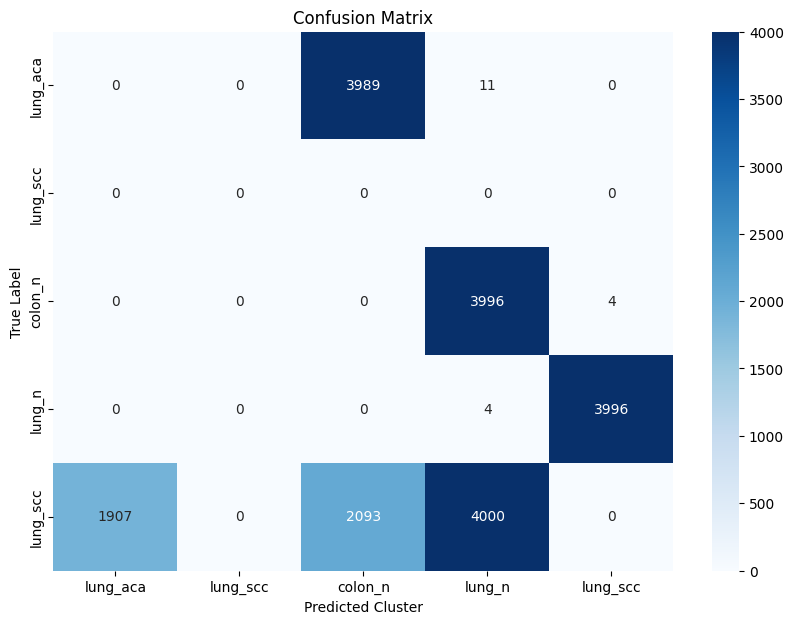

In [17]:



cluster_label_mapping = {
    0: 'lung_aca',
    1: 'lung_scc',
    2: 'colon_n',
    3: 'lung_n',
    4: 'lung_scc'
}

true_labels = np.load('./train_features/labels.npy')  # True labels
cluster_labels = np.load('./train_features/cluster_labels.npy')  # Cluster labels


categories = list(cluster_label_mapping.values())
category_to_index = {category: idx for idx, category in enumerate(categories)}


for label in np.unique(cluster_labels):
    if label not in cluster_label_mapping:
        print(f"Warning: Cluster label {label} not found in cluster_label_mapping.")


true_labels_indices = []
cluster_labels_indices = []


for label in true_labels:
    mapped_label = cluster_label_mapping.get(label, 'unknown')
    if mapped_label == 'unknown':
        print(f"Warning: True label {label} not found in cluster_label_mapping.")
        true_labels_indices.append(-1)  # Placeholder for missing labels
    else:
        true_labels_indices.append(category_to_index[mapped_label])


for label in cluster_labels:
    mapped_label = cluster_label_mapping.get(label, 'unknown')
    if mapped_label == 'unknown':
        print(f"Warning: Cluster label {label} not found in cluster_label_mapping.")
        cluster_labels_indices.append(-1)  # Placeholder for missing labels
    else:
        cluster_labels_indices.append(category_to_index[mapped_label])


true_labels_indices = np.array(true_labels_indices)
cluster_labels_indices = np.array(cluster_labels_indices)


conf_matrix = confusion_matrix(true_labels_indices, cluster_labels_indices, labels=list(range(len(categories))))


plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Cluster')
plt.ylabel('True Label')
plt.show()


In [ ]:
#FEATURE EXTRACTION AND CLASSIFICATION ON VALIDATION DATA

Cluster centers:
[[5.46752810e-02 2.25889385e-01 6.44221902e-03 ... 1.84301764e-01
  1.09812450e+00 2.91043520e-03]
 [1.02237964e+00 2.10404491e+00 6.95833564e-02 ... 2.82118320e-02
  5.38584948e-01 1.31687030e-01]
 [3.09051991e-01 8.44758749e-03 1.16513062e+00 ... 1.96283054e+00
  1.10208571e-01 1.11697626e+00]
 [1.31608397e-01 1.36672401e+00 1.73001021e-01 ... 8.05490613e-02
  1.71462333e+00 1.21544614e-01]
 [1.95995510e+00 4.44114208e-04 3.20634246e+00 ... 3.74996758e+00
  8.44160318e-02 3.00654650e+00]]
First 10 cluster labels:
[0 0 0 0 0 0 0 0 0 0]


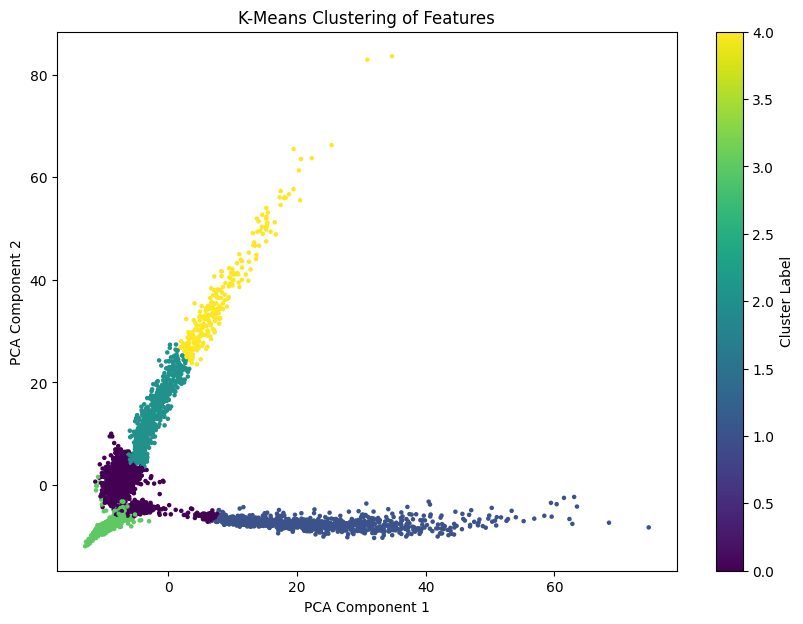

In [18]:
val_features_path = './val_features/features.npy'

val_features = np.load(val_features_path)

num_clusters = 5  

kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(val_features)

print(f"Cluster centers:\n{kmeans.cluster_centers_}")
print(f"First 10 cluster labels:\n{cluster_labels[:10]}")

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(val_features)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='viridis', s=5)
plt.colorbar(scatter, label='Cluster Label')
plt.title('K-Means Clustering of Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


Updated Cluster centers:
[[1.4485356e-01 2.9643834e-02 1.8380672e-02 ... 6.1046124e-02
  9.8699749e-02 1.4733672e-03]
 [2.2359765e-01 1.4107971e+00 3.7865520e-02 ... 4.2591870e-02
  4.6005678e-01 1.8739879e-02]
 [3.0466253e-01 4.1461587e-03 1.3248199e+00 ... 2.0592904e+00
  7.7865481e-02 1.2527821e+00]
 ...
 [3.4867159e-01 1.7798448e+00 3.4987628e-01 ... 1.0551703e-01
  2.3492692e+00 2.3930231e-01]
 [3.1799078e-04 2.4099445e-01 4.0911734e-03 ... 3.5975695e-02
  2.3087466e-01 2.0867884e-03]
 [5.5861378e+00 0.0000000e+00 7.0253696e+00 ... 6.9225583e+00
  2.1793485e-02 6.6457286e+00]]
First 10 updated cluster labels:
[ 4 11  4 11  9 11 11 11  9  4]


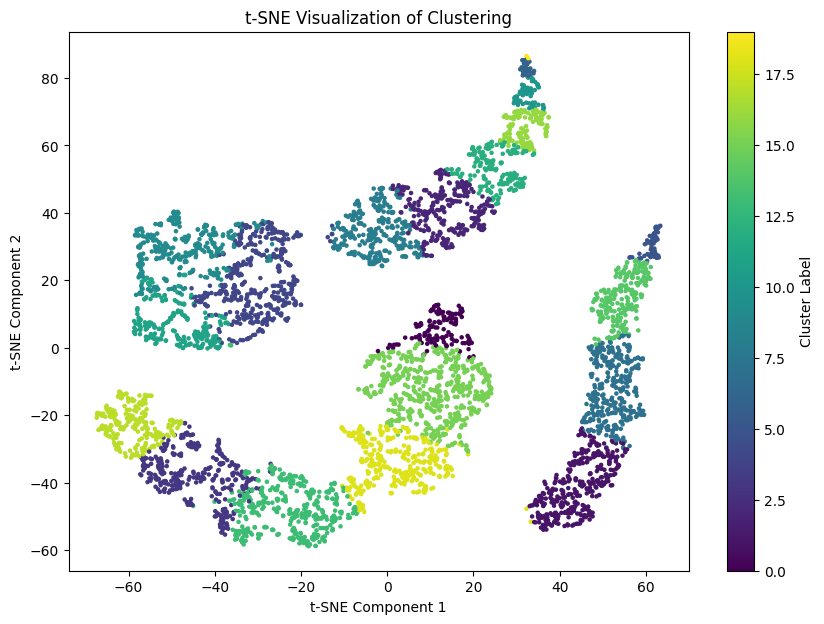

In [19]:
val_features_path = './val_features/features.npy'
val_features = np.load(val_features_path)

num_clusters = 20  

kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=0)
cluster_labels = kmeans.fit_predict(val_features)

print(f"Updated Cluster centers:\n{kmeans.cluster_centers_}")
print(f"First 10 updated cluster labels:\n{cluster_labels[:10]}")

pca = PCA(n_components=50)  # Reduce to 50 dimensions
reduced_features = pca.fit_transform(val_features)

tsne = TSNE(n_components=2, random_state=0)
reduced_features_2d = tsne.fit_transform(reduced_features)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_features_2d[:, 0], reduced_features_2d[:, 1], c=cluster_labels, cmap='viridis', s=5)
plt.colorbar(scatter, label='Cluster Label')
plt.title('t-SNE Visualization of Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


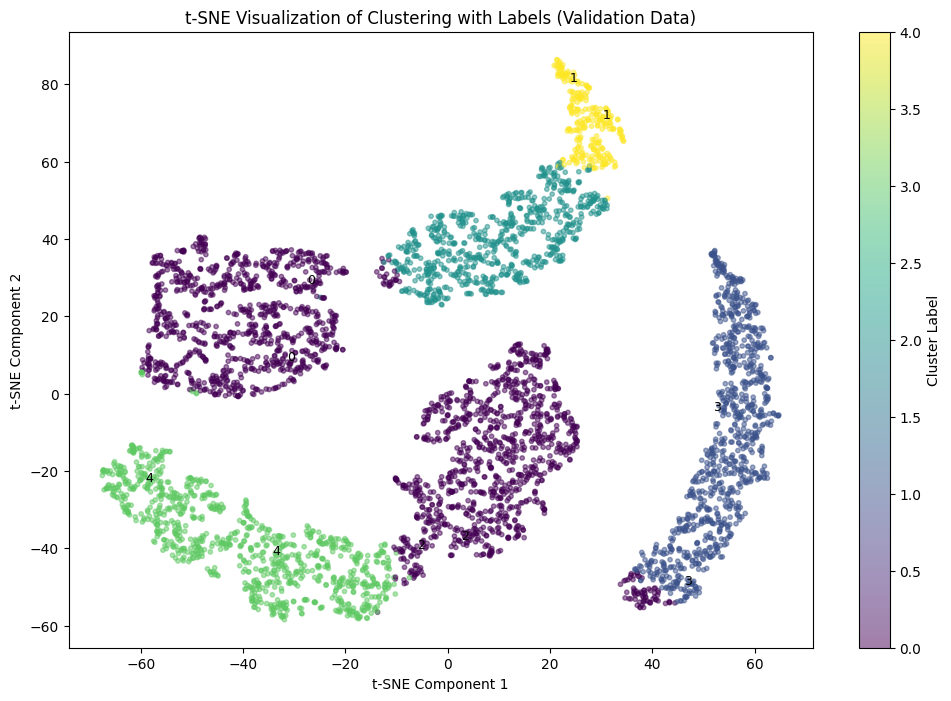

In [20]:
val_features = np.load('val_features/features.npy')
val_labels = np.load('val_features/labels.npy')

n_clusters = 5  
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(val_features)

pca = PCA(n_components=50)  
reduced_features = pca.fit_transform(val_features)

tsne = TSNE(n_components=2, random_state=0)
reduced_features_2d = tsne.fit_transform(reduced_features)


plt.figure(figsize=(12, 8))
scatter = plt.scatter(reduced_features_2d[:, 0], reduced_features_2d[:, 1], c=cluster_labels, cmap='viridis', s=10, alpha=0.5)
plt.colorbar(scatter, label='Cluster Label')


for i in range(0, len(reduced_features_2d), len(reduced_features_2d)//10):
    plt.text(reduced_features_2d[i, 0], reduced_features_2d[i, 1], str(val_labels[i]), fontsize=9, ha='right')

plt.title('t-SNE Visualization of Clustering with Labels (Validation Data)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


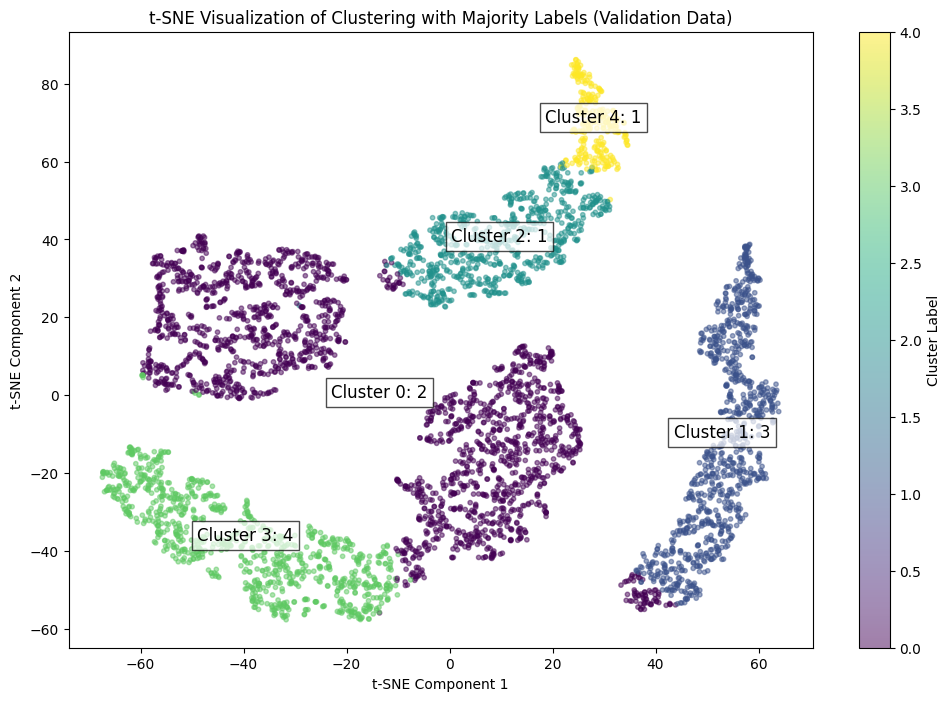

In [21]:
val_features = np.load('val_features/features.npy')
val_labels = np.load('val_features/labels.npy')
n_clusters = 5  
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(val_features)

def get_majority_label(labels, cluster_labels):
    cluster_label_mapping = {}
    for cluster_id in np.unique(cluster_labels):
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        cluster_labels_for_indices = labels[cluster_indices]
        majority_label = Counter(cluster_labels_for_indices).most_common(1)[0][0]
        cluster_label_mapping[cluster_id] = majority_label
    return cluster_label_mapping

cluster_label_mapping = get_majority_label(val_labels, cluster_labels)

mapped_labels = np.array([cluster_label_mapping[label] for label in cluster_labels])

pca = PCA(n_components=50)
reduced_features = pca.fit_transform(val_features)

tsne = TSNE(n_components=2, random_state=0)
reduced_features_2d = tsne.fit_transform(reduced_features)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(reduced_features_2d[:, 0], reduced_features_2d[:, 1], c=cluster_labels, cmap='viridis', s=10, alpha=0.5)
plt.colorbar(scatter, label='Cluster Label')
for cluster_id, majority_label in cluster_label_mapping.items():
    cluster_indices = np.where(cluster_labels == cluster_id)
    cluster_center = np.mean(reduced_features_2d[cluster_indices], axis=0)
    plt.text(cluster_center[0], cluster_center[1], f'Cluster {cluster_id}: {majority_label}', fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=0.7))

plt.title('t-SNE Visualization of Clustering with Majority Labels (Validation Data)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [22]:
labels = np.load('val_features/labels.npy')
print(f"Labels Shape: {labels.shape}")
print(f"First 10 Labels: {labels[:10]}")
label_categories = {0: 'colon_n', 1: 'colon_aca', 2: 'lung_n', 3: 'lung_aca'}
mapped_labels = [label_categories.get(label, 'unknown') for label in labels]
print(f"First 10 Mapped Labels: {mapped_labels[:10]}")


Labels Shape: (5000,)
First 10 Labels: [0 0 0 0 0 0 0 0 0 0]
First 10 Mapped Labels: ['colon_n', 'colon_n', 'colon_n', 'colon_n', 'colon_n', 'colon_n', 'colon_n', 'colon_n', 'colon_n', 'colon_n']


In [23]:
import numpy as np
labels = np.load('val_features/labels.npy')
unique_labels = np.unique(labels)
print(f"Unique Labels: {unique_labels}")

Unique Labels: [0 1 2 3 4]


In [24]:
label_mapping = {
    0: 'colon_aca',
    1: 'colon_n',
    2: 'lung_aca',
    3: 'lung_n',
    4: 'lung_scc',
}
labels = np.load('val_features/labels.npy')
label_counts = np.bincount(labels)
label_names_counts = {label_mapping.get(i, 'unknown'): count for i, count in enumerate(label_counts)}
print("Number of images per label:")
for label_name, count in label_names_counts.items():
    print(f"{label_name}: {count}")


Number of images per label:
colon_aca: 1000
colon_n: 1000
lung_aca: 1000
lung_n: 1000
lung_scc: 1000


In [25]:
features_path = './val_features/features.npy'
labels_path = './val_features/labels.npy'
cluster_labels_path = './val_features/cluster_labels.npy'
mapped_categories_path = './val_features/mapped_categories.npy'

all_features = np.load(features_path)

num_clusters = 5  


kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(all_features)


np.save(cluster_labels_path, cluster_labels)


val_labels = np.load(labels_path) 
cluster_labels = np.load(cluster_labels_path)  


label_categories = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

def get_majority_category(labels, cluster_labels, label_categories):
    cluster_label_mapping = {}
    unique_clusters = np.unique(cluster_labels)

    for cluster_id in unique_clusters:
        
        cluster_indices = np.where(cluster_labels == cluster_id)[0] 
        cluster_labels_for_indices = labels[cluster_indices]
        majority_label_index = Counter(cluster_labels_for_indices).most_common(1)[0][0]
        majority_category = label_categories[majority_label_index]
        cluster_label_mapping[cluster_id] = majority_category

    return cluster_label_mapping

cluster_label_mapping = get_majority_category(val_labels, cluster_labels, label_categories)

print("Cluster Label Mapping:")
for cluster_id, category in cluster_label_mapping.items():
    print(f"Cluster {cluster_id}: {category}")
print("**********")


mapped_categories = np.array([cluster_label_mapping[label] for label in cluster_labels])


np.save(mapped_categories_path, mapped_categories)

def evaluate_clusters(labels, cluster_labels):
    for cluster_id in np.unique(cluster_labels):
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        cluster_true_labels = labels[cluster_indices]
        label_counts = Counter(cluster_true_labels)
        print(f"Cluster {cluster_id}:")
        for label, count in label_counts.items():
            print(f"  Label {label}: {count} samples")


evaluate_clusters(val_labels, cluster_labels)


Cluster Label Mapping:
Cluster 0: colon_n
Cluster 1: lung_scc
Cluster 2: lung_aca
Cluster 3: lung_n
Cluster 4: lung_n
**********
Cluster 0:
  Label 1: 584 samples
Cluster 1:
  Label 0: 9 samples
  Label 2: 5 samples
  Label 4: 950 samples
Cluster 2:
  Label 0: 991 samples
  Label 1: 416 samples
  Label 2: 994 samples
  Label 3: 3 samples
  Label 4: 50 samples
Cluster 3:
  Label 3: 328 samples
Cluster 4:
  Label 2: 1 samples
  Label 3: 669 samples


Cluster Label Mapping:
Cluster 0: colon_n
Cluster 1: lung_scc
Cluster 2: lung_aca
Cluster 3: lung_n
Cluster 4: lung_n
Silhouette Score of Validation Data: 0.42364785075187683
Davies-Bouldin Index of Validation Data: 0.8063677620542409
Calinski-Harabasz Index of Validation Data: 3143.119397310185


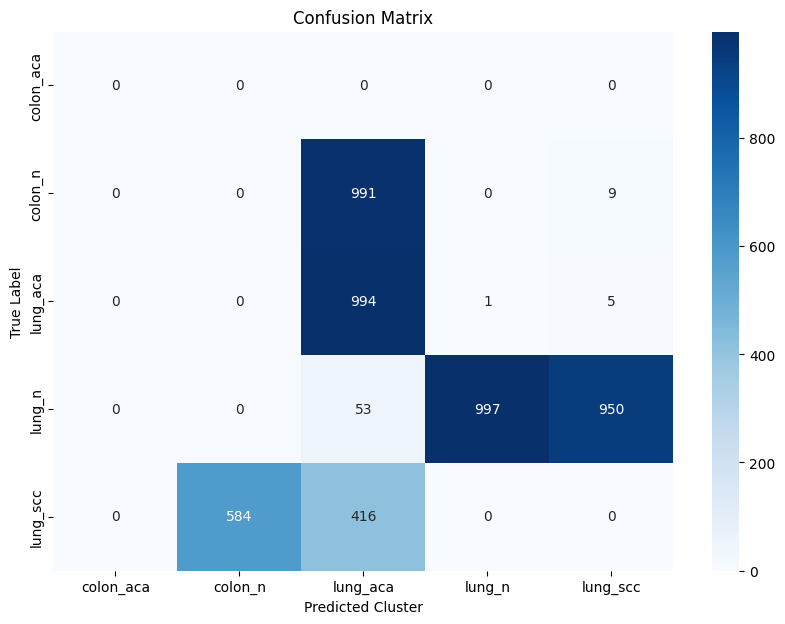

In [26]:
features = np.load(features_path)

num_clusters = 5  


kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features)


np.save(cluster_labels_path, cluster_labels)


val_labels = np.load(labels_path)  
cluster_labels = np.load(cluster_labels_path)  


label_categories = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

def get_majority_category(labels, cluster_labels, label_categories):
    cluster_label_mapping = {}
    unique_clusters = np.unique(cluster_labels)

    for cluster_id in unique_clusters:
       
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        
        cluster_labels_for_indices = labels[cluster_indices]
        majority_label_index = Counter(cluster_labels_for_indices).most_common(1)[0][0]
        majority_category = label_categories[majority_label_index]
        cluster_label_mapping[cluster_id] = majority_category

    return cluster_label_mapping


cluster_label_mapping = get_majority_category(val_labels, cluster_labels, label_categories)


print("Cluster Label Mapping:")
for cluster_id, category in cluster_label_mapping.items():
    print(f"Cluster {cluster_id}: {category}")

mapped_categories = np.array([cluster_label_mapping[label] for label in cluster_labels])

np.save(mapped_categories_path, mapped_categories)


silhouette_avg = silhouette_score(features, cluster_labels)
db_index = davies_bouldin_score(features, cluster_labels)
ch_index = calinski_harabasz_score(features, cluster_labels)

print(f"Silhouette Score of Validation Data: {silhouette_avg}")
print(f"Davies-Bouldin Index of Validation Data: {db_index}")
print(f"Calinski-Harabasz Index of Validation Data: {ch_index}")


category_to_index = {category: idx for idx, category in enumerate(label_categories)}


true_labels_indices = []
cluster_labels_indices = []


for label in val_labels:
    mapped_label = cluster_label_mapping.get(label, 'unknown')
    if mapped_label == 'unknown':
        true_labels_indices.append(-1) 
    else:
        true_labels_indices.append(category_to_index[mapped_label])


for label in cluster_labels:
    mapped_label = cluster_label_mapping.get(label, 'unknown')
    if mapped_label == 'unknown':
        cluster_labels_indices.append(-1)  
    else:
        cluster_labels_indices.append(category_to_index[mapped_label])

true_labels_indices = np.array(true_labels_indices)
cluster_labels_indices = np.array(cluster_labels_indices)


conf_matrix = confusion_matrix(true_labels_indices, cluster_labels_indices, labels=list(range(len(label_categories))))

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_categories, yticklabels=label_categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Cluster')
plt.ylabel('True Label')
plt.show()


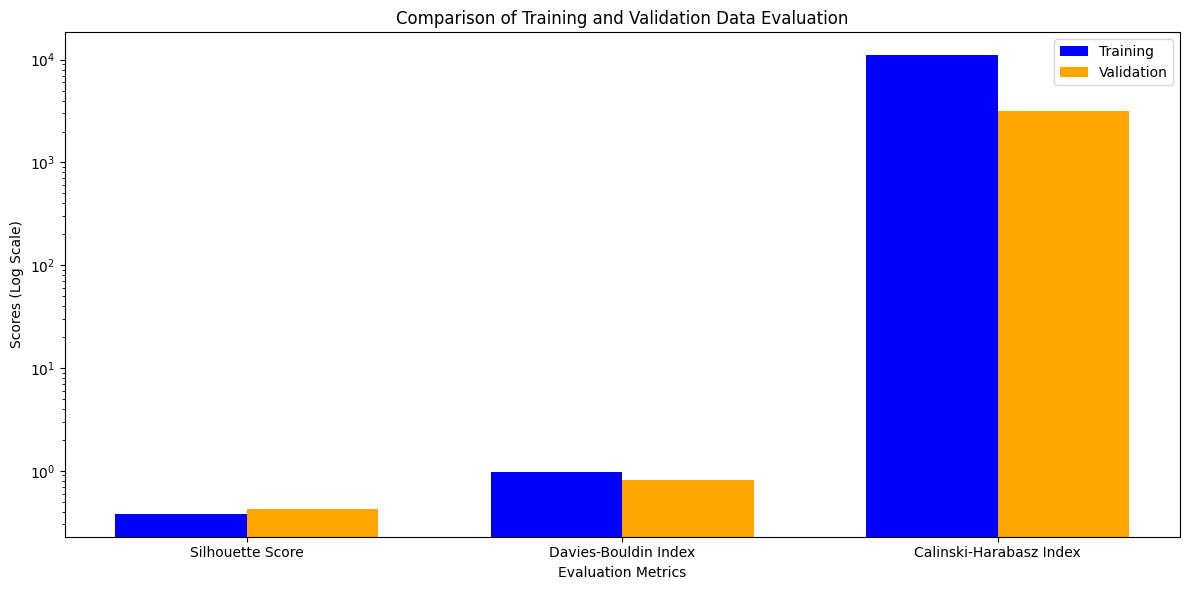

In [12]:
train_silhouette = 0.38099122047424316
train_davies_bouldin = 0.9689326087992347
train_calinski_harabasz = 11044.233643831121

val_silhouette = 0.42364785075187683
val_davies_bouldin = 0.8063677620542409
val_calinski_harabasz = 3143.119397310185

train_metrics = [train_silhouette, train_davies_bouldin, train_calinski_harabasz]
val_metrics = [val_silhouette, val_davies_bouldin, val_calinski_harabasz]
metric_names = ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index']

def plot_comparison(train_metrics, val_metrics, metric_names):
    bar_width = 0.35
    index = np.arange(len(metric_names))
    
    plt.figure(figsize=(12, 6))
    
    # Use a logarithmic scale to better visualize the differences
    plt.bar(index, train_metrics, bar_width, label='Training', color='blue')
    plt.bar(index + bar_width, val_metrics, bar_width, label='Validation', color='orange')
    
    plt.yscale('log')
    plt.xlabel('Evaluation Metrics')
    plt.ylabel('Scores (Log Scale)')
    plt.title('Comparison of Training and Validation Data Evaluation')
    plt.xticks(index + bar_width / 2, metric_names)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_comparison(train_metrics, val_metrics, metric_names)

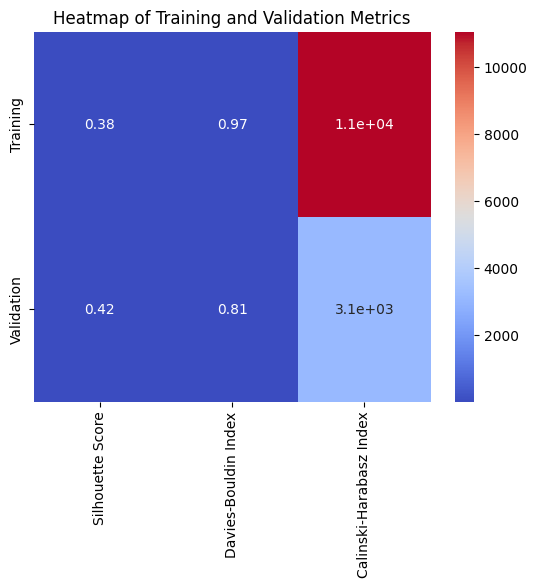

In [14]:
def plot_heatmap(train_metrics, val_metrics, metric_names):
    data = np.array([train_metrics, val_metrics])
    sns.heatmap(data, annot=True, cmap='coolwarm', xticklabels=metric_names, yticklabels=['Training', 'Validation'])
    plt.title('Heatmap of Training and Validation Metrics')
    plt.show()

plot_heatmap(train_metrics, val_metrics, metric_names)

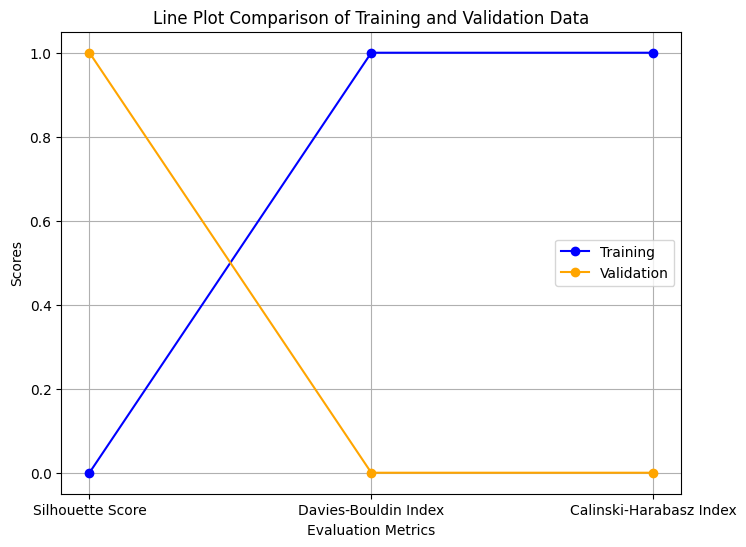

In [16]:
def plot_line_chart(train_metrics, val_metrics, metric_names):
    plt.figure(figsize=(8, 6))
    plt.plot(metric_names, train_metrics, marker='o', label='Training', color='blue')
    plt.plot(metric_names, val_metrics, marker='o', label='Validation', color='orange')
    plt.xlabel('Evaluation Metrics')
    plt.ylabel('Scores')
    plt.title('Line Plot Comparison of Training and Validation Data')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_line_chart(train_metrics, val_metrics, metric_names)


C:\Users\anoop\AppData\Local\Temp\ipykernel_19808\2135285808.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Training', 'Validation'])


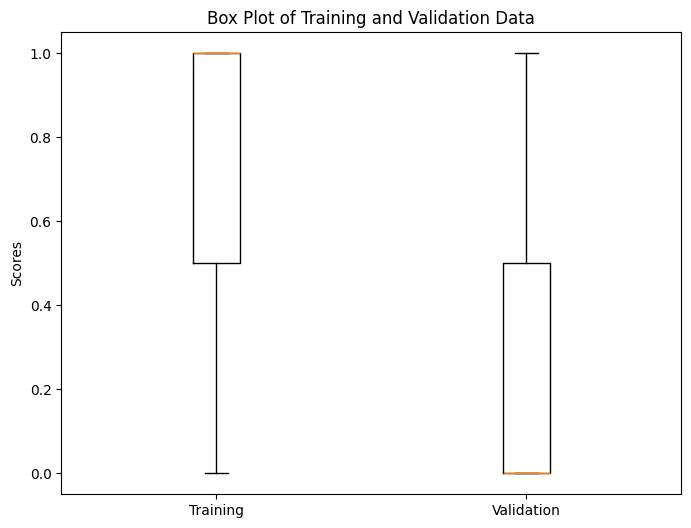

In [17]:
def plot_box_chart(train_metrics, val_metrics, metric_names):
    data = [train_metrics, val_metrics]
    plt.figure(figsize=(8, 6))
    plt.boxplot(data, labels=['Training', 'Validation'])
    plt.xticks([1, 2], ['Training', 'Validation'])
    plt.ylabel('Scores')
    plt.title('Box Plot of Training and Validation Data')
    plt.show()

plot_box_chart(train_metrics, val_metrics, metric_names)
